In [94]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

import random
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import norm

random.seed(13)

In [95]:
device = torch.device('cpu')
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

# 4 datasets

## 1) Heteroskedastic & continous

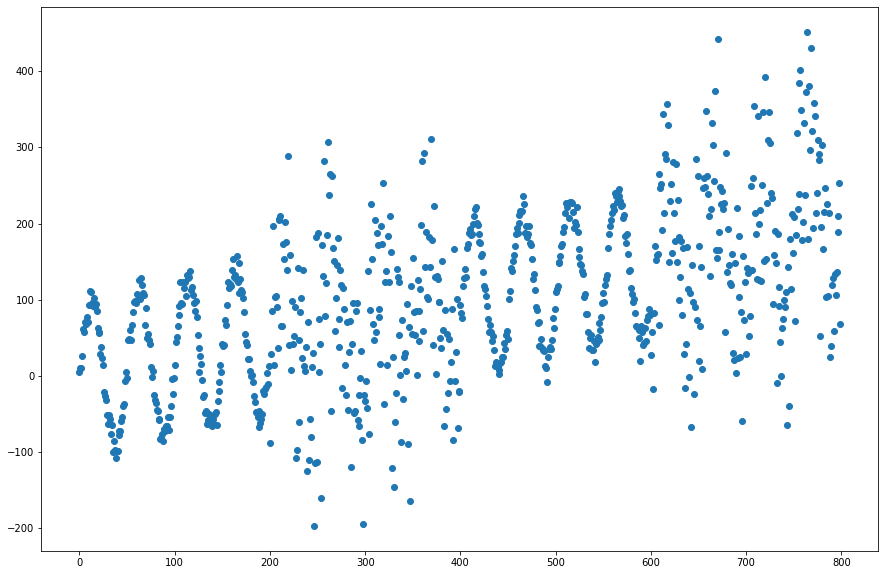

In [96]:
lenght = 200

series_het_and_cont = np.sin(0.125*np.arange(0,lenght*4))*100 + np.random.normal(scale=np.concatenate((np.array([1]*lenght),
                                                                                          np.array([8]*lenght),
                                                                                          np.array([1]*lenght),
                                                                                          np.array([8]*lenght)), axis = None))*10+np.arange(lenght*4)/4
plt.figure(figsize = (15,10)) 
X_1 = np.arange(0, lenght*4)
y_1 = series_het_and_cont
plt.scatter(X_1, y_1);


## 2) Gomoskedastic & continous

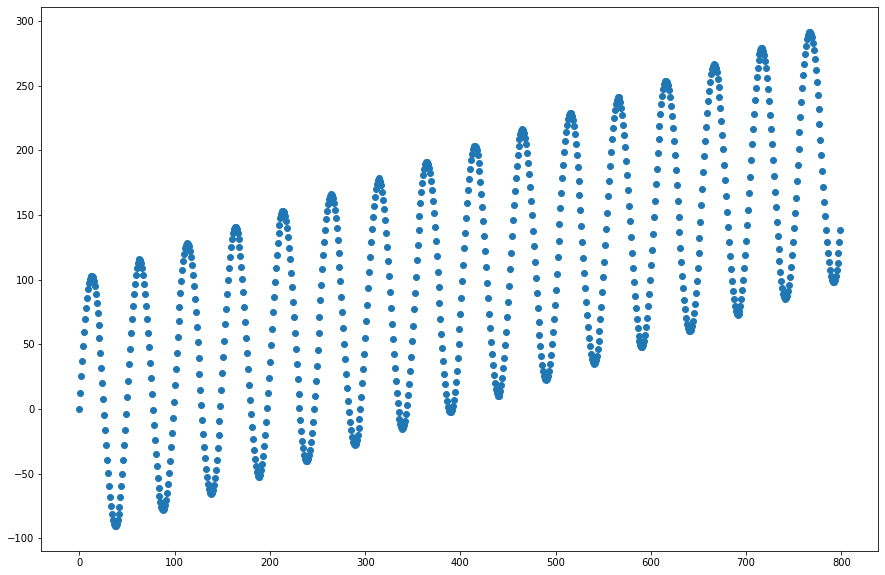

In [97]:
series_gom_and_cont =  np.sin(0.125*np.arange(0,lenght*4))*100 + np.arange(lenght*4)/4

plt.figure(figsize = (15,10)) 
X_2 = np.arange(0, lenght*4)
y_2 = series_gom_and_cont
plt.scatter(X_2, y_2);


## 3) Heteroskedastic & discontinous

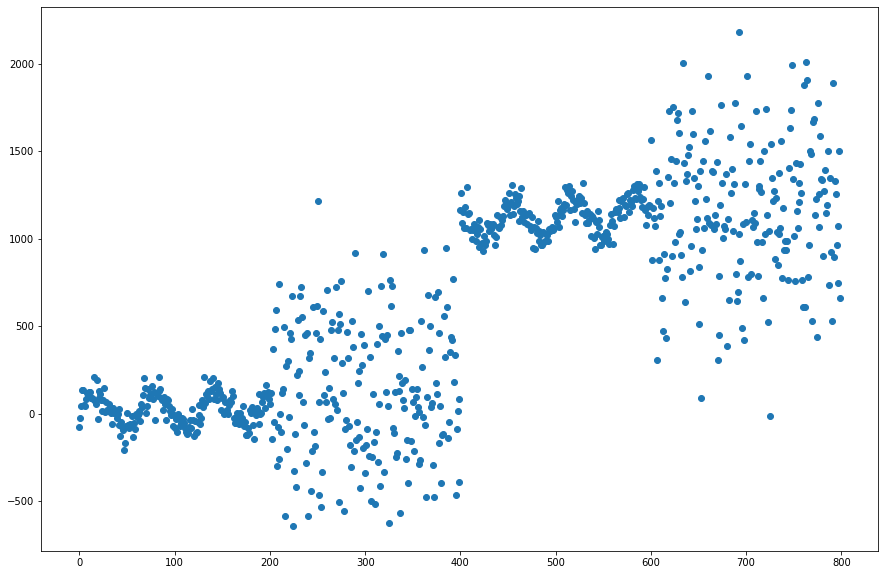

In [98]:
a = [0]*(lenght*2)
b = [1000]*(lenght*2)
c = np.concatenate((a,b))
c


series_het_and_discont = np.sin(0.1*np.arange(0,lenght*4))*100 + np.random.normal(scale=np.concatenate((np.array([1]*lenght),
                                                                                          np.array([8]*lenght),
                                                                                          np.array([1]*lenght),
                                                                                          np.array([8]*lenght)), axis = None))*50 + np.arange(lenght*4)/4 + c


plt.figure(figsize = (15,10)) 
X_3 = np.arange(0, lenght*4)
y_3 = series_het_and_discont
plt.scatter(X_3, y_3);



## 4) Gomoskedastic and discontinuous

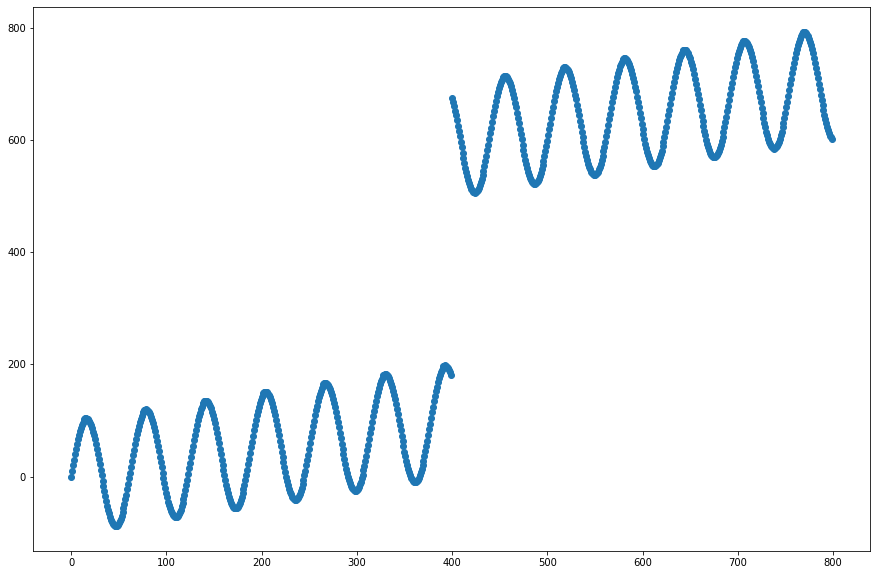

In [99]:
series_gom_and_discont = np.sin(0.1*np.arange(0,lenght*4))*100 + np.arange(lenght*4)/4 + c/2


plt.figure(figsize = (15,10)) 
X_4 = np.arange(0, lenght*4)
y_4 = series_gom_and_discont
plt.scatter(X_4, y_4);



# Test Uncertainty on artificial datasets

### 1) UE on Heteroskedastic & continous

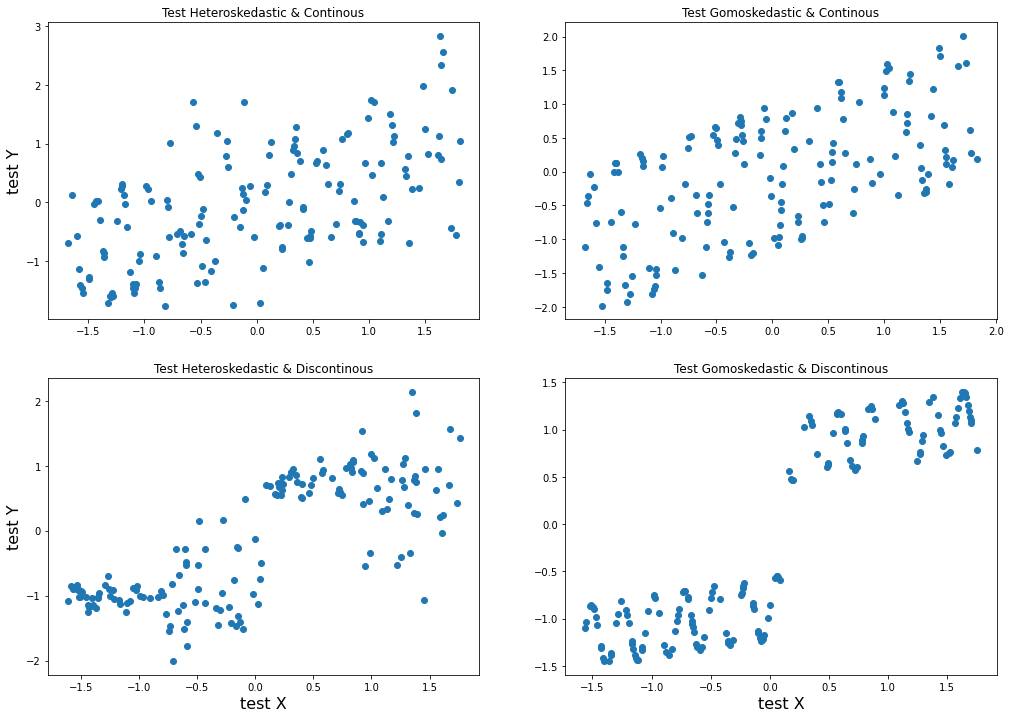

In [100]:
def data_preprocess(input_X, input_y, task_type = "regression"):
    
    input_X=list(input_X)
    input_X = np.array([[i] for i in input_X], dtype = np.float32)
    
    X = {}
    y = {}
    
    X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
        input_X, input_y, train_size=0.8
    )
    X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
        X['train'], y['train'], train_size=0.8
    )

    # not the best way to preprocess features, but enough for the demonstration
    preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
    
    X = {
        k: torch.tensor(preprocess.fit_transform(v), device=device)
        for k, v in X.items()
    }
    y = {k: torch.tensor(v, device=device) for k, v in y.items()}

    # !!! CRUCIAL for neural networks when solving regression problems !!!
    if task_type == 'regression':
        y_mean = y['train'].mean().item()
        y_std = y['train'].std().item()
        y = {k: (v - y_mean) / y_std for k, v in y.items()}
    else:
        y_std = y_mean = None

    if task_type != 'multiclass':
        y = {k: v.float() for k, v in y.items()}
    
    return X, y


X_h_c, y_h_c = data_preprocess(X_1, y_1)
X_g_c, y_g_c = data_preprocess(X_2, y_2)
X_h_d, y_h_d = data_preprocess(X_3, y_3)
X_g_d, y_g_d = data_preprocess(X_4, y_4)




# plot prepared test data
plt.figure(figsize = (17,12))


plt.subplot(2, 2, 1)
plt.ylabel("test Y", fontsize = 16)
plt.scatter(X_h_c['test'], y_h_c['test'])
plt.title("Test Heteroskedastic & Continous")

plt.subplot(2, 2, 2)
plt.scatter(X_g_c['test'], y_g_c['test'])
plt.title("Test Gomoskedastic & Continous")

plt.subplot(2, 2, 3)
plt.xlabel("test X", fontsize = 16)
plt.ylabel("test Y", fontsize = 16)
plt.scatter(X_h_d['test'], y_h_d['test'])
plt.title("Test Heteroskedastic & Discontinous")

plt.subplot(2, 2, 4)
plt.xlabel("test X", fontsize = 16)
plt.scatter(X_g_d['test'], y_g_d['test'])
plt.title("Test Gomoskedastic & Discontinous");


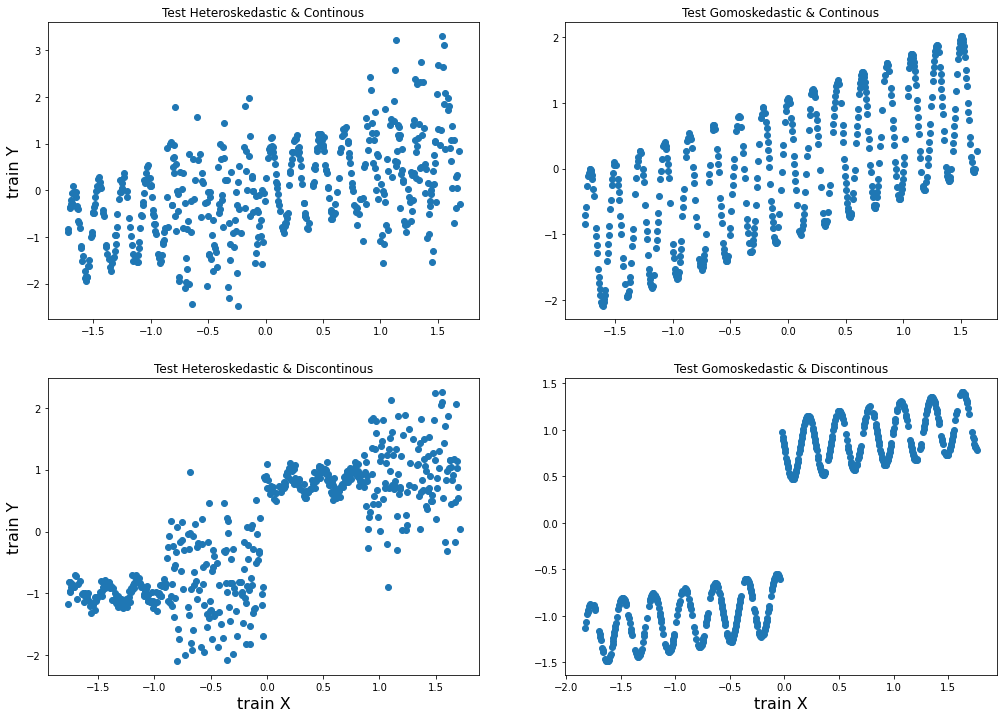

In [101]:
# plot prepared test data
plt.figure(figsize = (17,12))


plt.subplot(2, 2, 1)
plt.xlabel("train X", fontsize = 16)
plt.ylabel("train Y", fontsize = 16)
plt.scatter(X_h_c['train'], y_h_c['train'])
plt.xlabel('')
plt.title("Test Heteroskedastic & Continous")

plt.subplot(2, 2, 2)
plt.scatter(X_g_c['train'], y_g_c['train'])
plt.title("Test Gomoskedastic & Continous")

plt.subplot(2, 2, 3)
plt.xlabel("train X", fontsize = 16)
plt.ylabel("train Y", fontsize = 16)
plt.scatter(X_h_d['train'], y_h_d['train'])
plt.title("Test Heteroskedastic & Discontinous")

plt.subplot(2, 2, 4)
plt.xlabel("train X", fontsize = 16)
plt.scatter(X_g_d['train'], y_g_d['train'])
plt.title("Test Gomoskedastic & Discontinous");


# Model application and UE

In [102]:
X_h_c, y_h_c = data_preprocess(X_1, y_1)
X_g_c, y_g_c = data_preprocess(X_2, y_2)
X_h_d, y_h_d = data_preprocess(X_3, y_3)
X_g_d, y_g_d = data_preprocess(X_4, y_4)


def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def uncertainity_estimate(x, model, num_samples, l2):
    outputs = np.hstack([model(x_num = x, x_cat = None).cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    N = x.shape[1]
    tau = l2 * (1. - 0.2) / (2. * N * 1e-5)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std


def gaussian_entropy(sigma: float) -> float:
        return 0.5*np.log(np.exp(1)*2*np.pi*sigma**2)  
    





        
      

def model_application_and_UE(X, y, d_out = 1, lr = 0.001, 
                             weight_decay = 0.0,
                             n_epochs = 20,
                             entropy_number_of_samples = 5,
                             batch_size = 128,
                             seed = 13,
                             task_type = 'regression',
                             number_of_samples = 10):
    

    model = rtdl.FTTransformer.make_baseline(
        n_num_features = X['train'].size()[1],
        #n_num_features = len(X_h_c['train']),
        cat_cardinalities = None,
        d_token = 160,
        n_blocks = 80,
        attention_dropout = 0.2,
        ffn_d_hidden = 50,
        ffn_dropout = 0.2,
        residual_dropout = 0.1,
        last_layer_query_idx = [-1],
        kv_compression_ratio = None,
        kv_compression_sharing = None,
        d_out = d_out)  
    

    model.to(device)
    optimizer = (
        model.make_default_optimizer()
        if isinstance(model, rtdl.FTTransformer)
        else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    )

    loss_fn = (
        F.binary_cross_entropy_with_logits
        if task_type == 'binclass'
        else F.cross_entropy
        if task_type == 'multiclass'
        else F.mse_loss
    )
    
    print("model established")
    
    
    if task_type == 'regression':
        y_mean = y['train'].mean().item()
        y_std = y['train'].std().item()
    
    def apply_model(x_num, x_cat=None):
        if isinstance(model, rtdl.FTTransformer):
            model.train()
            return model(x_num, x_cat)
        elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
            assert x_cat is None
            return model(x_num)
        else:
            raise NotImplementedError(
                f'Looks like you are using a custom model: {type(model)}.'
                ' Then you have to implement this branch first.'
                )


    @torch.no_grad()
    def evaluate(part):
        model.eval()
        prediction = []
        for batch in zero.iter_batches(X[part], batch_size):
            prediction.append(apply_model(batch))
        prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
        target = y[part].cpu().numpy()

        if task_type == 'binclass':
            prediction = np.round(scipy.special.expit(prediction))
            score = sklearn.metrics.accuracy_score(target, prediction)
        elif task_type == 'multiclass':
            prediction = prediction.argmax(1)
            score = sklearn.metrics.accuracy_score(target, prediction)
        else:
            assert task_type == 'regression'
            score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
        return score

    
    


    # Create a dataloader for batches of indices
    # Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
    train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

    # Create a progress tracker for early stopping
    # Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
    progress = zero.ProgressTracker(patience=100)

    
    print(f'Test score before training: {evaluate("test"):.4f}')
    print("###################################################")
    
    report_frequency = len(X['train']) // 5
    for epoch in range(1, n_epochs + 1):
        for iteration, batch_idx in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            x_batch = X['train'][batch_idx]
            y_batch = y['train'][batch_idx]
            loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
            loss.backward()
            optimizer.step()
            if iteration % report_frequency == 0:
                print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate('val')
        test_score = evaluate('test')
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
        progress.update((-1 if task_type == 'regression' else 1) * val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH', end='')
        print()
        if progress.fail:
            break
            
    plt.figure(figsize = (12,12))

    plt.ylabel("Density Estimation", fontsize = 16)
    plt.xlabel("10 different model output estimations", fontsize = 16)
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='y')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='r')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='b')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='g')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    plt.show();
    
    plt.figure(figsize = (12,12))
    plt.title("Actual y test distribution")
    sns.kdeplot(y['test']);
    
    
    def entropy_estimate_transformer(number_of_samples: int, data: np.ndarray, seed: int) -> float:
    
        rng = np.random.default_rng(2021)
        rng.random(seed)

        a = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
        b = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
        c = np.concatenate((a, b), axis=0)

        for i in range(number_of_samples-2):
            d = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
            c = np.concatenate((c, d), axis=0)

        sigmas = []
        for i in range(c.shape[1]):
            sigmas.append(norm.fit(c[:,i])[1])

        entropies = []
        for sigma in sigmas:
            entropies.append(gaussian_entropy(sigma))

        total_entropy = np.mean(entropies)

        return total_entropy
    
    test_entropy = entropy_estimate_transformer(number_of_samples = entropy_number_of_samples,
                                                data = X['test'],
                                                seed = seed)
    
    
    data = X['test']
    
    iters_uncertainty = 20
    
    X['train'], y['train'] = zip(*sorted(zip(X['train'], y['train'])))
    X['val'], y['val'] = zip(*sorted(zip(X['val'], y['val'])))
    X['test'], y['test'] = zip(*sorted(zip(X['test'], y['test'])))


    # x_test = X['test'].reshape(-1).detach().numpy()
    # x_obs = X['train'].reshape(-1).detach().numpy()

    # y_obs = y['train'].reshape(-1).detach().numpy()
    # y_test = y['test'].reshape(-1).detach().numpy()

    x_test = np.array(X['test'])
    x_obs = np.array(X['train'])

    y_obs = np.array(y['train'])
    y_test = np.array(y['test'])


    lengthscale = 0.01
    n_std = 2 # number of standard deviations to plot
    y_mean, y_std = uncertainity_estimate(torch.Tensor(x_test).view(-1,1).to(device), model, iters_uncertainty, lengthscale)
    
    y_pred = model(x_num = torch.Tensor(X['test']).view(-1,1).to(device), x_cat = None).reshape(-1).detach().numpy()
    
    plt.figure(figsize=(15,9))
    plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
    plt.plot(x_test, y_test, ls='--', color='r', label='true')
    plt.plot(x_test, y_pred,  ls="none", marker="x", color="r", label="predicted")
    
    for i in range(n_std):
        plt.fill_between( x_test,
            y_mean - y_std * ((i+1.)),
            y_mean + y_std * ((i+1.)),
            color="b",
            alpha=0.1)
    plt.legend()
    plt.grid()

    a = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    b = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    c = np.concatenate((a, b), axis=0)

    for i in range(number_of_samples-2):
        d = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
        c = np.concatenate((c, d), axis=0)

    sigmas = []
    for i in range(c.shape[1]):
        sigmas.append(norm.fit(c[:,i])[1])

    entropies = []
    for sigma in sigmas:
        entropies.append(gaussian_entropy(sigma))

    total_entropy = np.mean(entropies)
    
    print("the overall entropy is {}".format(total_entropy))
    
    plt.figure(figsize = (14,10))
    plt.xlabel("Entropy values", fontsize = 16)
    plt.ylabel("Distribution", fontsize = 16)
    sns.kdeplot(entropies)
    plt.show();
    
    plt.xlabel("X", fontsize = 16)
    plt.ylabel("Y", fontsize = 16)
    plt.scatter(X['test'], y['test'])
    plt.title("{}".format(namestr(X, globals())))
    
    

model established
Test score before training: 0.9082
###################################################
(epoch) 1 (batch) 0 (loss) 0.8934
Epoch 001 | Validation score: 0.8607 | Test score: 0.8325 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.6589
Epoch 002 | Validation score: 0.8340 | Test score: 0.8115 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.6006
Epoch 003 | Validation score: 0.8556 | Test score: 0.8661
(epoch) 4 (batch) 0 (loss) 0.6450
Epoch 004 | Validation score: 0.8198 | Test score: 0.7920 <<< BEST VALIDATION EPOCH
(epoch) 5 (batch) 0 (loss) 0.6632
Epoch 005 | Validation score: 0.8298 | Test score: 0.8267
(epoch) 6 (batch) 0 (loss) 0.6478
Epoch 006 | Validation score: 0.8501 | Test score: 0.8167
(epoch) 7 (batch) 0 (loss) 0.6753
Epoch 007 | Validation score: 0.8066 | Test score: 0.7882 <<< BEST VALIDATION EPOCH
(epoch) 8 (batch) 0 (loss) 0.6263
Epoch 008 | Validation score: 0.8175 | Test score: 0.8276
(epoch) 9 (batch) 0 (loss) 0.5825
Epoch 009 | Validatio

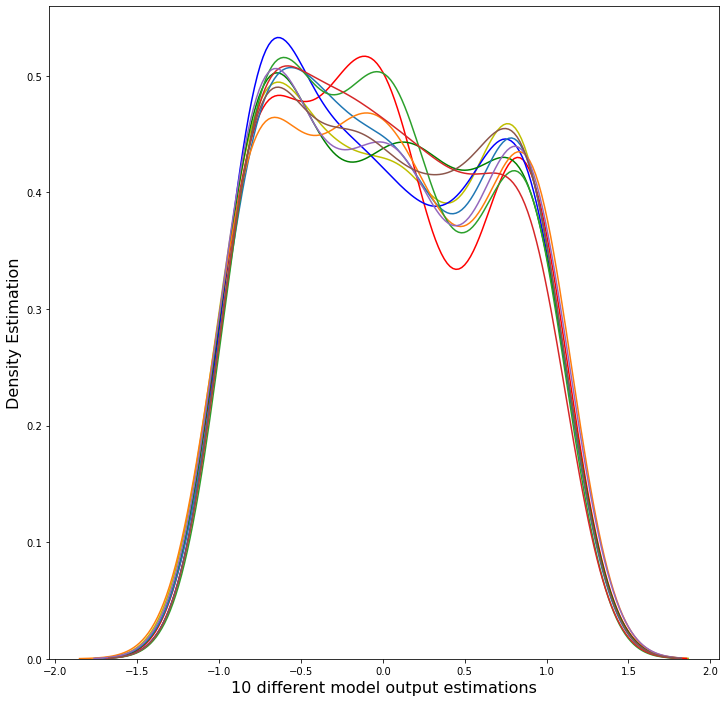

the overall entropy is -0.7403748152610967


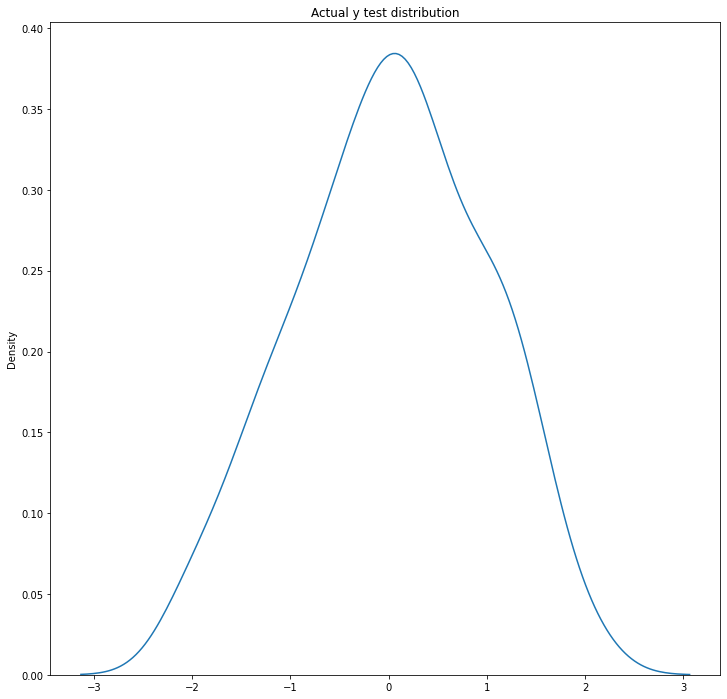

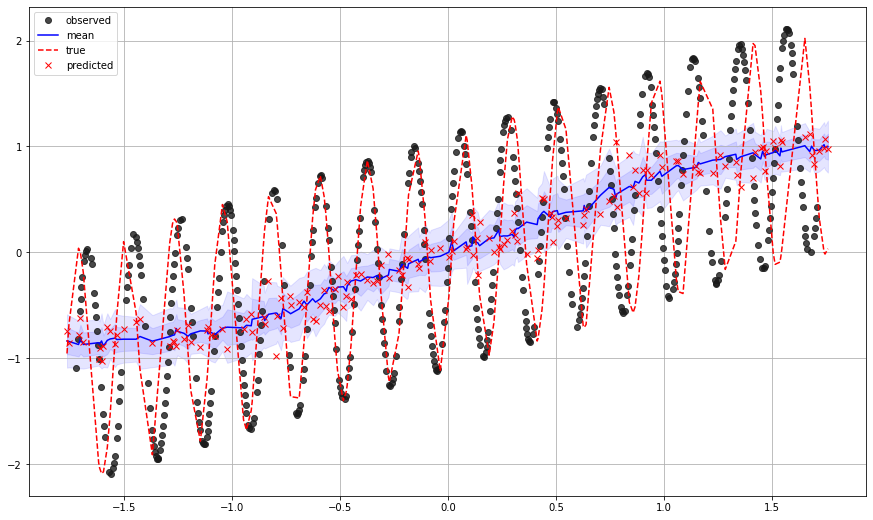

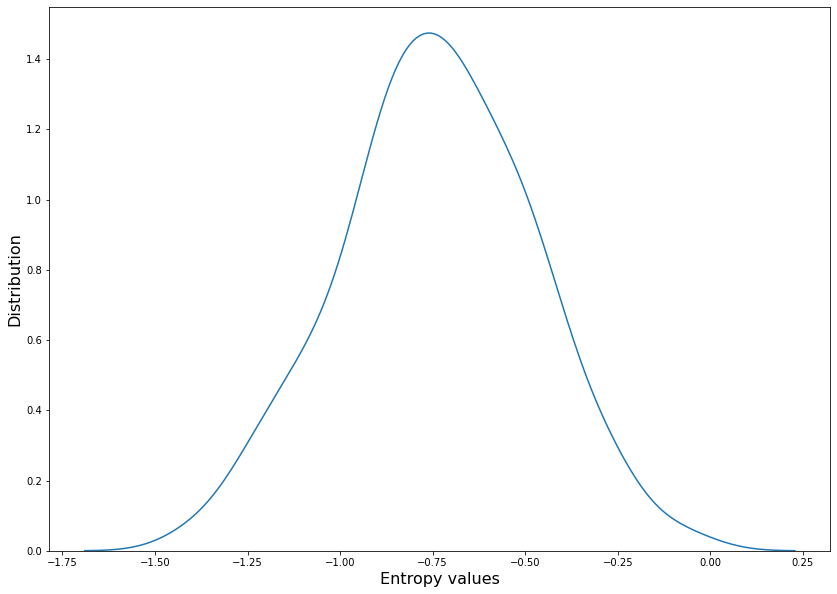

model established
Test score before training: 0.9714
###################################################
(epoch) 1 (batch) 0 (loss) 1.3296
Epoch 001 | Validation score: 0.7925 | Test score: 0.8207 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.8437
Epoch 002 | Validation score: 0.7457 | Test score: 0.8421 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.8995
Epoch 003 | Validation score: 0.7169 | Test score: 0.8157 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.8198
Epoch 004 | Validation score: 0.7686 | Test score: 0.8208
(epoch) 5 (batch) 0 (loss) 0.7644
Epoch 005 | Validation score: 0.7624 | Test score: 0.8314
(epoch) 6 (batch) 0 (loss) 0.7799
Epoch 006 | Validation score: 0.7222 | Test score: 0.8318
(epoch) 7 (batch) 0 (loss) 0.7871
Epoch 007 | Validation score: 0.7566 | Test score: 0.8412
(epoch) 8 (batch) 0 (loss) 0.7679
Epoch 008 | Validation score: 0.7025 | Test score: 0.8288 <<< BEST VALIDATION EPOCH
(epoch) 9 (batch) 0 (loss) 0.7968
Epoch 009 | Validatio

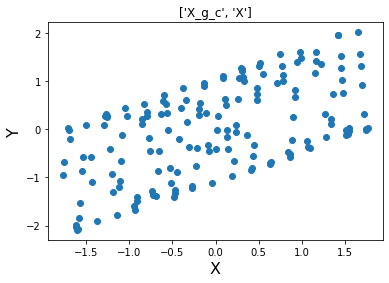

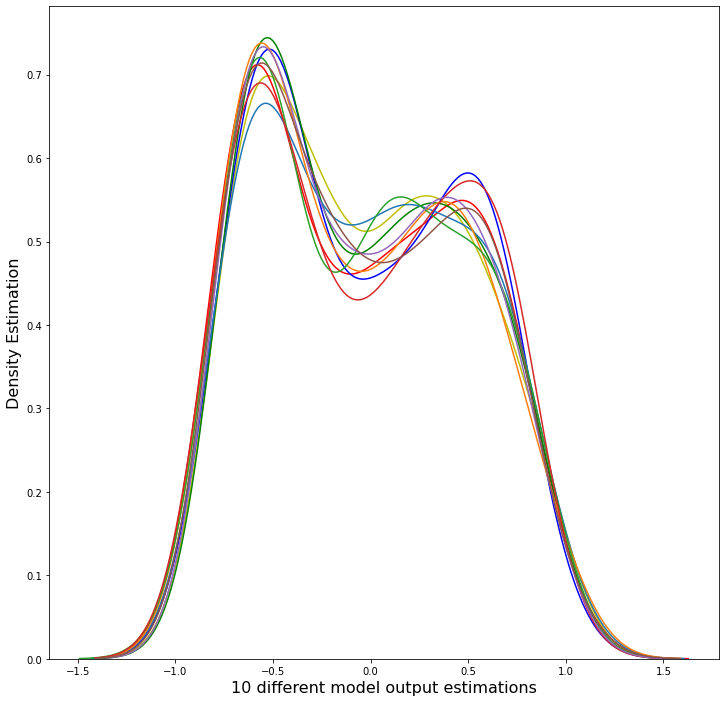

the overall entropy is -0.8342255027062567


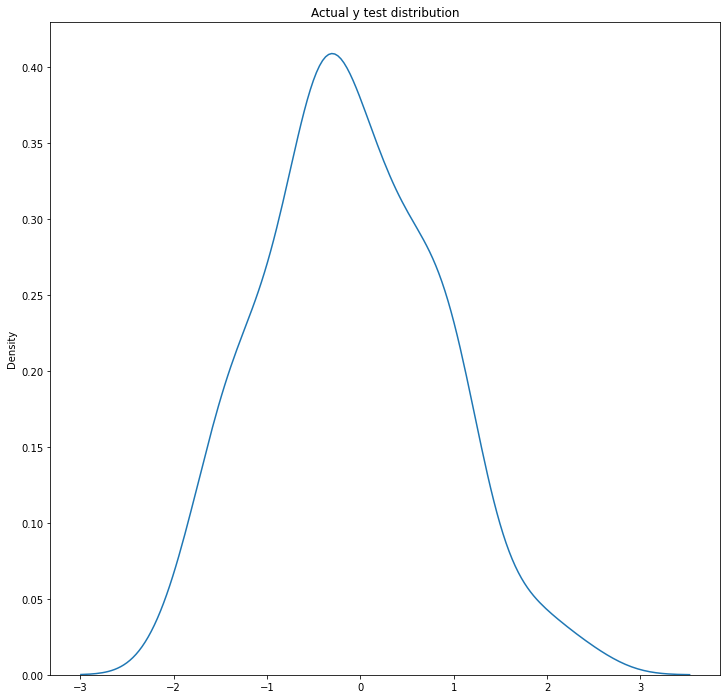

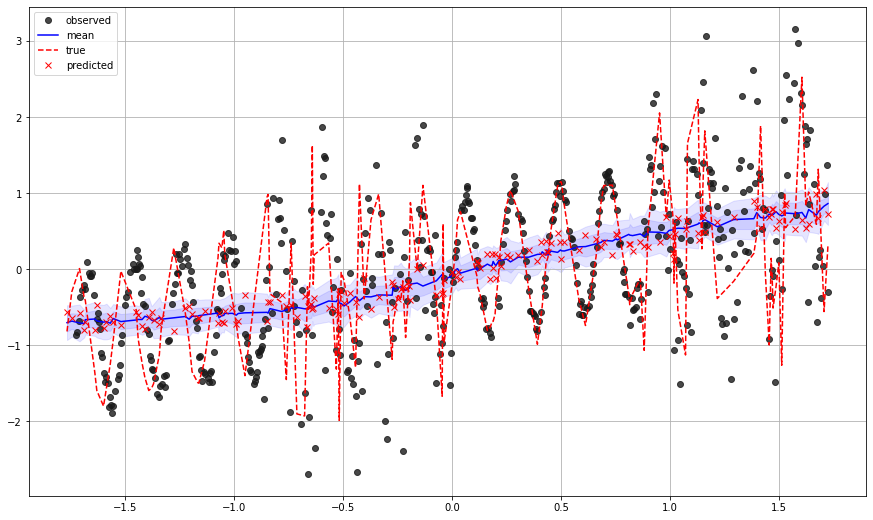

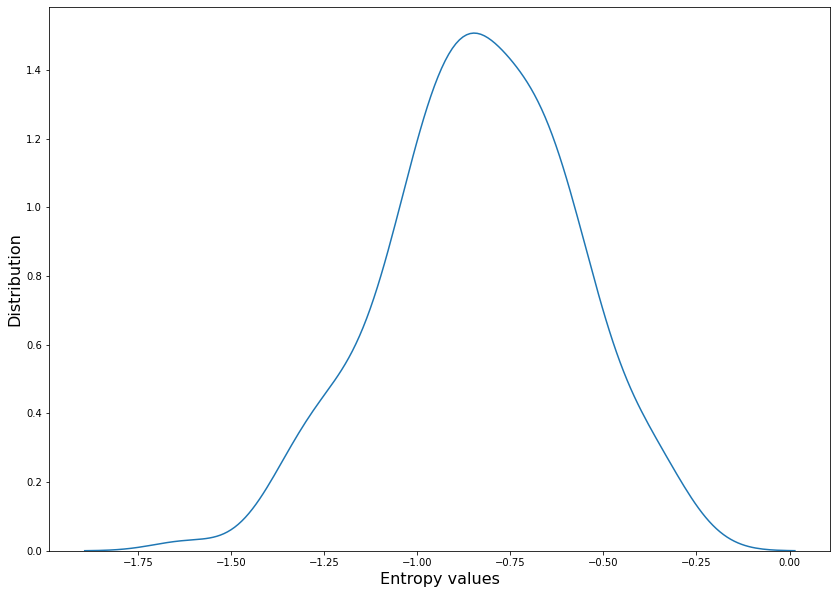

model established
Test score before training: 0.9858
###################################################
(epoch) 1 (batch) 0 (loss) 0.9208
Epoch 001 | Validation score: 0.4921 | Test score: 0.4755 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.3313
Epoch 002 | Validation score: 0.4515 | Test score: 0.4301 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.1912
Epoch 003 | Validation score: 0.4016 | Test score: 0.4254 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.1533
Epoch 004 | Validation score: 0.3635 | Test score: 0.4236 <<< BEST VALIDATION EPOCH
(epoch) 5 (batch) 0 (loss) 0.0905
Epoch 005 | Validation score: 0.3558 | Test score: 0.3824 <<< BEST VALIDATION EPOCH
(epoch) 6 (batch) 0 (loss) 0.1074
Epoch 006 | Validation score: 0.3373 | Test score: 0.4098 <<< BEST VALIDATION EPOCH
(epoch) 7 (batch) 0 (loss) 0.0912
Epoch 007 | Validation score: 0.3282 | Test score: 0.3395 <<< BEST VALIDATION EPOCH
(epoch) 8 (batch) 0 (loss) 0.1023
Epoch 008 | Validation score: 0.334

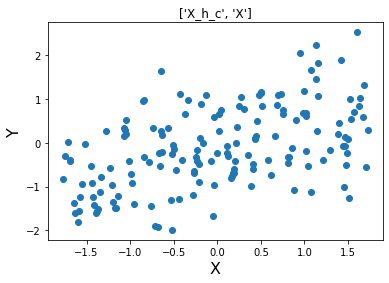

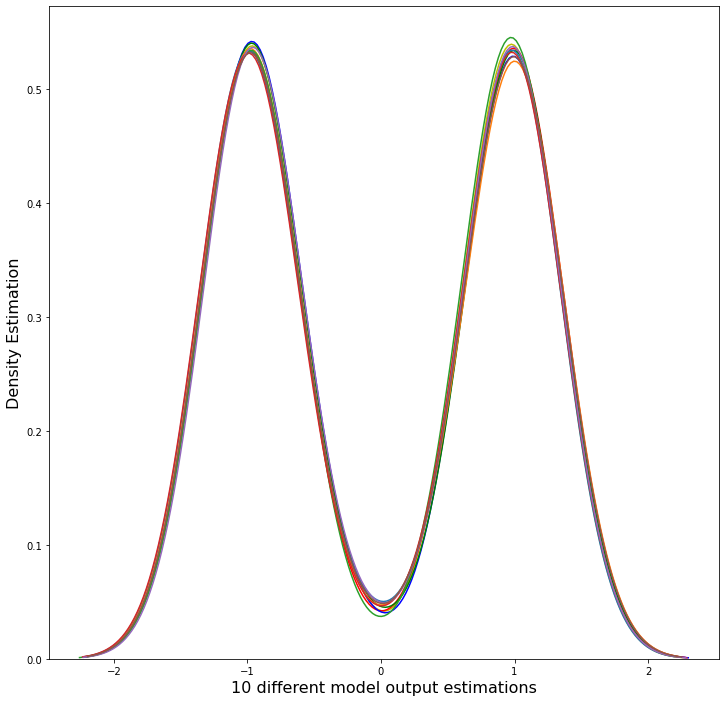

the overall entropy is -1.2010494834281193


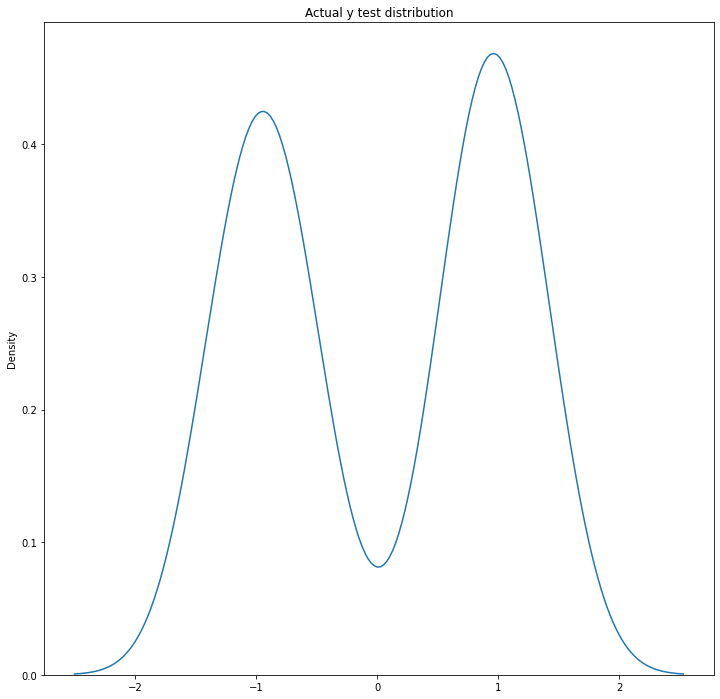

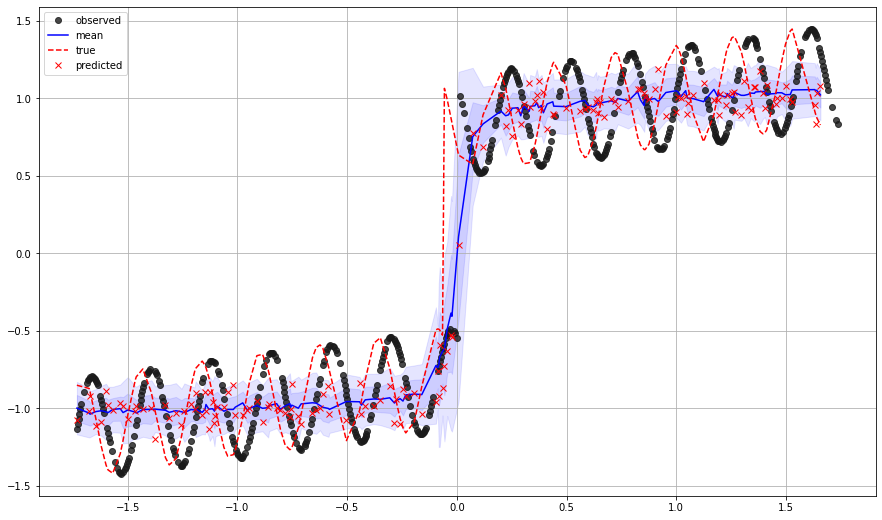

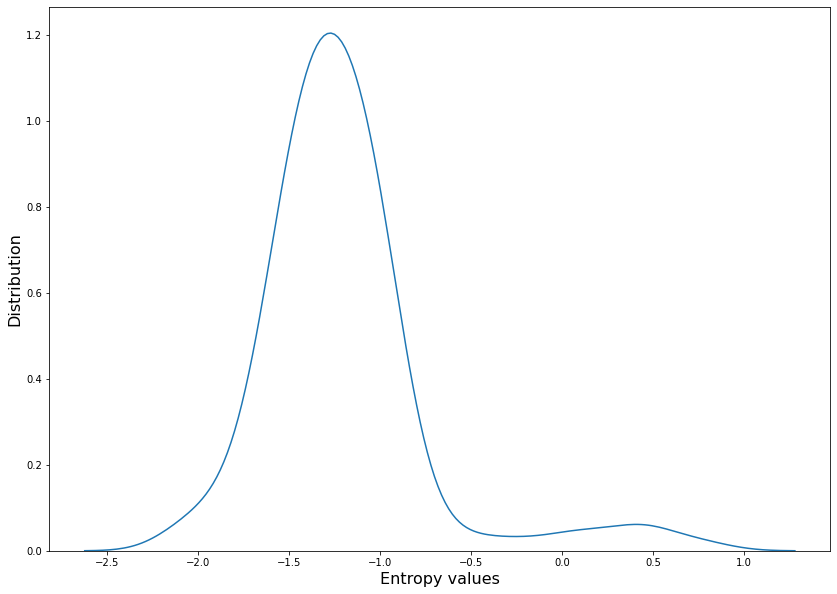

model established
Test score before training: 1.2281
###################################################
(epoch) 1 (batch) 0 (loss) 1.4415
Epoch 001 | Validation score: 0.8304 | Test score: 0.7140 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.4843
Epoch 002 | Validation score: 0.7075 | Test score: 0.8531 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.5027
Epoch 003 | Validation score: 0.6656 | Test score: 0.5953 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.2817
Epoch 004 | Validation score: 0.6123 | Test score: 0.6765 <<< BEST VALIDATION EPOCH
(epoch) 5 (batch) 0 (loss) 0.3130
Epoch 005 | Validation score: 0.5900 | Test score: 0.6707 <<< BEST VALIDATION EPOCH
(epoch) 6 (batch) 0 (loss) 0.2661
Epoch 006 | Validation score: 0.6076 | Test score: 0.6027
(epoch) 7 (batch) 0 (loss) 0.2599
Epoch 007 | Validation score: 0.5491 | Test score: 0.6143 <<< BEST VALIDATION EPOCH
(epoch) 8 (batch) 0 (loss) 0.2962
Epoch 008 | Validation score: 0.5481 | Test score: 0.6360 <<<

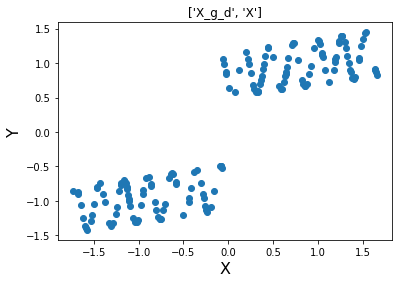

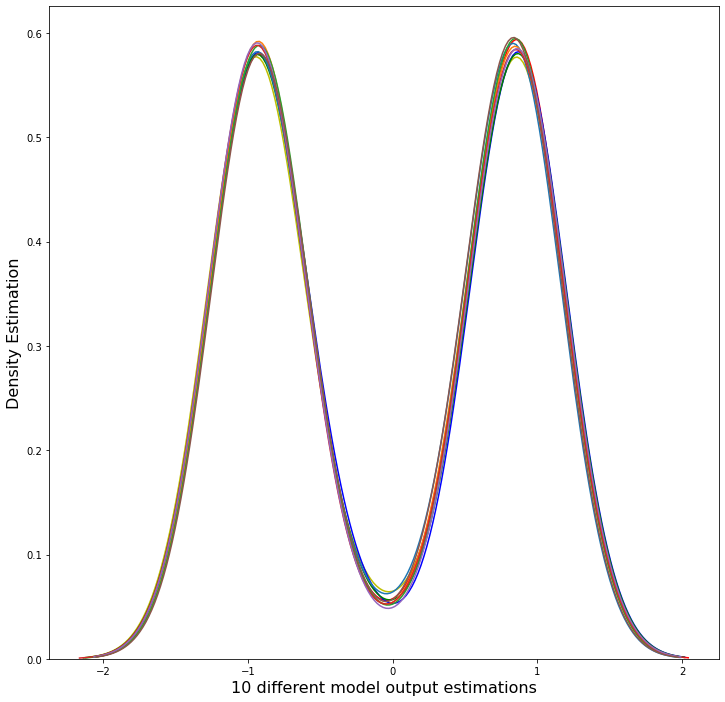

In [ ]:
for (X, y) in [(X_g_c, y_g_c), (X_h_c, y_h_c), (X_g_d, y_g_d), (X_h_d, y_h_d)]:
    model_application_and_UE(X, y, n_epochs=30, entropy_number_of_samples = 20, weight_decay=0.01)